<a href="https://colab.research.google.com/github/dinael2000/GreekMinusculeFont/blob/main/notebooks/da3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Anything 3 (DA3) Usage Example

This notebook demonstrates how to use Depth Anything 3 for camera poses and depth estimation.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ByteDance-Seed/Depth-Anything-3.git

Cloning into 'Depth-Anything-3'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 151 (delta 33), reused 119 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 4.78 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
%cd /content/Depth-Anything-3/

/content/Depth-Anything-3


In [3]:
!pip install -r requirements.txt

In [4]:
!pip install -e .

Obtaining file:///content/Depth-Anything-3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for depth-anything-3 (pyproject.toml) ... done
  Created wheel for depth-anything-3: filename=depth_anything_3-0.0.0-py3-none-any.whl size=10568 sha256=deb1fb233a18e9ec37ced4e98d0de8e30f33fe1697185140dbb23fb7d158a6b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-9_fhdjjz/wheels/a4/a6/b9/c3ad67065497f9ae7738b6d42a8001fbb063ae56096d7b0043
Successfully built depth-anything-3


In [5]:
# Install required packages
!pip install depth-anything-3

In [6]:
%cd src/

/content/Depth-Anything-3/src


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from depth_anything_3.api import DepthAnything3
from depth_anything_3.utils.visualize import visualize_depth

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DepthAnything3.from_pretrained("depth-anything/DA3NESTED-GIANT-LARGE")
model = model.to(device)
model.eval()

print(f"Model loaded on {device}")


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



[WARN ] Dependency `gsplat` is required for rendering 3DGS. Install via: pip install git+https://github.com/nerfstudio-project/gsplat.git@0b4dddf04cb687367602c01196913cde6a743d70


config.json: 0.00B [00:00, ?B/s]

[INFO ] using SwiGLU layer as FFN
[INFO ] using MLP layer as FFN


model.safetensors:   0%|          | 0.00/6.76G [00:00<?, ?B/s]

Model loaded on cuda


In [25]:
import numpy as np

all_depths = {}
all_extrinsics = {}
all_intrinsics = {}

In [31]:
from PIL import Image

# Load sample images and run inference
image_dir = "/content/input_data"
output_dir = "/content/output_data"

image_list = os.listdir(image_dir)

valid_exts = [".jpg", ".jpeg", ".png"]

image_list = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in valid_exts]

print(image_list)

# Run inference
for image_name in image_list:
    image_path = os.path.join(image_dir, image_name)
    print(f"\nProcessing {image_path} ...")

    # Load as PIL image
    pil_image = Image.open(image_path).convert("RGB")

    # Run inference (single-image, wrapped in list)
    prediction = model.inference(
        image=[pil_image],
        process_res=504,
        process_res_method="upper_bound_resize",
        export_dir=output_dir,
        export_format="npz"  # saves .npz automatically
    )

    # If single image, prediction is already a Prediction object
    # Access depth, intrinsics, extrinsics
    depth = prediction.depth
    extrinsics = prediction.extrinsics
    intrinsics = prediction.intrinsics

    # Save depth as .npy
    npy_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + "_depth.npy")
    np.save(npy_path, depth)

    # Save depth as visual .png
    png_path = os.path.join(output_dir, os.path.splitext(image_name)[0] + "_depth.png")
    # Remove extra dimensions
    depth_array = np.array(depth)
    depth_array = np.squeeze(depth_array)  # now shape should be H x W

    # Normalize to 0-255 for visualization
    depth_normalized = (depth_array - depth_array.min()) / (depth_array.max() - depth_array.min() + 1e-8)
    depth_img = (depth_normalized * 255).astype(np.uint8)

    # Save as PNG
    Image.fromarray(depth_img).save(png_path)

    # Print shapes
    print(f"Depth shape: {depth.shape}")
    print(f"Extrinsics: {extrinsics.shape if extrinsics is not None else 'None'}")
    print(f"Intrinsics: {intrinsics.shape if intrinsics is not None else 'None'}")
    print(f"Saved .npy -> {npy_path}")
    print(f"Saved .png -> {png_path}")

['sb1-rev.jpg', 'sb450-rev.jpg', 'sb15-obv.jpg', 'sb448-obv.jpg', 'sb1-obv.jpg', 'sb376-rev.jpg', 'sb376-obv.jpg', 'sb2-obv.jpg', 'sb50-obv.jpg', 'sb356-obv.jpg', 'sb39-rev.jpg', 'sb7-obv.jpg', 'sb370-rev-1.png', 'sb370-obv-2.png', 'sb42-rev.jpg', 'sb7-rev.jpg', 'sb42-obv.jpg', 'sb89-obv.jpg', 'sb358-obv.jpg', 'sb15-rev.jpg', 'sb2-rev.jpg', 'sb356-rev.jpg', 'sb450-obv.jpg', 'sb50-rev.jpg', 'sb5-obv.jpg', 'sb113-rev.jpg', 'sb72-rev.jpg', 'sb113-obv.jpg', 'sb72-obv.jpg', 'sb358-rev.jpg', 'sb39-obv.jpg', 'sb5-rev.jpg', 'sb370-obv-1.png', 'sb448-rev.jpg', 'sb370-rev-2.png', 'sb89-rev.jpg']

Processing /content/input_data/sb1-rev.jpg ...
[INFO ] Processed Images Done taking 0.1377120018005371 seconds. Shape:  torch.Size([1, 3, 336, 504])
[INFO ] Model Forward Pass Done. Time: 1.5787925720214844 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010514259338378906 seconds
[INFO ] Export Results Done. Time: 0.00036787986755371094 seconds
Depth shape: (1, 336, 504)
Extrinsics: (1, 3, 4)
I

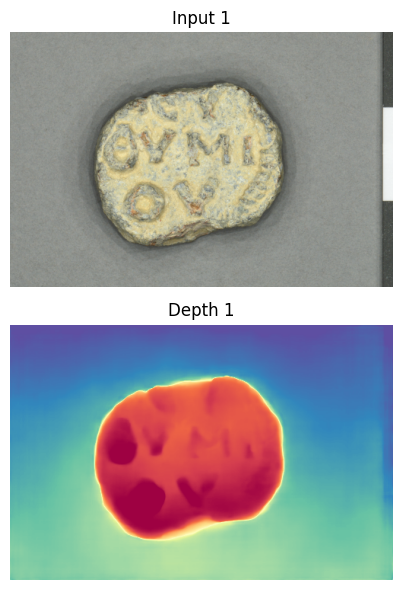

In [34]:
# Visualize input images and depth maps
n_images = prediction.depth.shape[0]

fig, axes = plt.subplots(2, n_images, figsize=(12, 6))

if n_images == 1:
    axes = axes.reshape(2, 1)

for i in range(n_images):
    # Show original image
    if prediction.processed_images is not None:
        axes[0, i].imshow(prediction.processed_images[i])
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis('off')

    # Show depth map
    depth_vis = visualize_depth(prediction.depth[i], cmap="Spectral")
    axes[1, i].imshow(depth_vis)
    axes[1, i].set_title(f"Depth {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()